## <font color='SeaGreen'>__Table of Contents__</font><br>

* [1. Loading the IMDB dataset](#imdb)<br>
* [2. Data Preparation](#2nd)<br>
* [3. Model Definition](#3rd)<br>
* [4. Validation Set](#4th)<br>
* [5. Training the Model](#5th)<br>
    * [5.1. Loss and Accuracy](#6th)<br>
* [6. Evaluation on Test Data](#7th)<br>

<a class="anchor" id="imdb">

# 1. Loading the IMDB dataset

</a>

IMDB dataset: 

> 50000 reviews from the Internet Movie Database
> Split into 25000 reviews for training and 25000 reviews for testing, each set consisting of 50% negative and 50% positive reviews.

The IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

__When you run it the first time, ~ 80 MB of data will be downloaded to your machine__

In [2]:
from tensorflow.keras.datasets import imdb

# num_words=10000 means you’ll only keep the top 10000 most frequently occurring words in the training data. Rare words will be discarded. 
# train_data and test_data are lists of reviews. Each review is a list of word indices (encoding a sequence of words). 
# train_labels and test_labels are lists of 0s and 1s, where 0 stands for negative and 1 stands for positive.

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

2023-12-03 12:47:54.368658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data is already processed. With 'train_data[0]' you can see the words indices and with 'train_labels[0]' you can see 1 (meaning positive review)

In [3]:
# train_data[0]
# train_labels[0]

<a class="anchor" id="2nd">

# 2. Data preparation

</a>

Encoding the integer sequences into a binary matrix. You can’t feed lists of integers into a neural network. You have to turn your lists into tensors. There are 2 ways to achieve this: 

> — Using an Embedding layer (commonly used for NLP problems) <p>

> — One-hot encode your lists to turn them into vectors of 0s and 1s. This would mean turning the sequence [3, 5] into a 10,000-dimensional vector that would be all 0s except for indices 3 and 5, which would be 1s. Then you could use as the first layer in your network a Dense layer, capable of handling floating-point vector data. <p>

Let’s go with the latter solution to vectorize the data.

In [11]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) # Creates an all-zero matrix of shape len(sequences), dimension
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1 # Sets specific indices of results[i] to 1s
    return results    

# Vectorizing the data
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

# Vectorizing the labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

__The data is ready to be fed into a neural network.__

__So:__<p>
The input data is vectors, and the labels are scalars (1s and 0s).

A simple stack of fully connected (Dense) layers with __relu activations__: Dense(16,activation='relu') is a type of network that performs well on such a problem

The argument being passed to each Dense layer (16) is the number of hidden units of the layer. A hidden unit is a dimension in the representation space of the layer.

Such Dense layer with a relu activation implements the following chain of operations:

> output = relu(dot(W, input) + b)

Having 16 hidden units means the weight matrix W will have shape (input_dimension, 16): the dot product with W will project the input data onto a 16-dimensional representation space (and then you’ll add the bias vector b and apply the relu operation). 

You can intuitively understand the dimensionality of your representation space as “how much freedom you’re allowing the network to have when learning internal representations.”

__But:__ <p>
> — Having more hidden units (a higher-dimensional representation space) allows your network to learn more-complex representations <p>
> — it makes the network more computationally expensive and may lead to learning unwanted patterns (patterns that will improve performance on the training data but not on the test data).

2 key architecture decisions to be made about such a stack of Dense layers:
> 1. How many layers to use
> 2. How many hidden units to choose for each layer

There are practical principles to guide you in making these choices. In this case we'll use: 
> — Two intermediate layers with 16 hidden units each <p>
> — A third layer that will output the scalar prediction regarding the sentiment of the current review <p>

The intermediate layers will use __relu__ as their activation function, and the final layer will use a __sigmoid activation__ to output a probability, indicating how likely the sample is to have the target “1”: how likely the review is to be positive.

What are activation functions, and why are they necessary? 

Without an activation function like relu (also called a non-linearity), the Dense layer would consist of two linear operations — a dot product and an addition: 

> output = dot(W, input) + b <p>

So the layer could only learn linear transformations (affine transformations) of the input data: the hypothesis space of the layer would be the set of all possible linear transformations of the input data into a 16-dimensional space. Such a hypothesis space is too restricted and adding more layers wouldn’t extend the hypothesis space.

In order to get access to a much richer hypothesis space that would benefit from deep representations, you need a non-linearity, or activation function. relu is the most popular activation function in deep learning.

<a class="anchor" id="3rd">

# 3. Model Definition

</a>

In [16]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, Sequential

model = Sequential()

model.add(Dense(16, activation='relu', input_dim=10000))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Now, it's time to choose a __loss function__ and an __optimizer__. 

This is a binary classification problem and the end of the network is a single-unit layer with a sigmoid activation (the output of the network is a probability), __binary_crossentropy loss__ will be used. 

> Crossentropy is a quantity from the field of Information Theory that measures the distance between probability distributions or, in this case, between the ground-truth distribution and your predictions.

In [17]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

<a class="anchor" id="4th">

# 4. Validation Set

</a>

During training, in order to monitor the accuracy of the model on data it has never seen before, will be created a validation set by setting apart 10000 samples from the original training data.

> Train set: 15 000 samples <p>
> Validation: 10 000 samples <p>
> Test: 25 000 <p>

In [18]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

<a class="anchor" id="5th">

# 5. Training the Model

</a>

The model will be trained for 20 epochs (20 iterations over all samples in the __x_train__ and __y_train__ tensors), in mini-batches of 512 samples. <p>
The loss and accuracy will be monitored on the validation set.

In [19]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 6s 161ms/step - loss: 0.5456 - accuracy: 0.7671 - val_loss: 0.4244 - val_accuracy: 0.8404
Epoch 2/20
30/30 [==============================] - 1s 32ms/step - loss: 0.3334 - accuracy: 0.8943 - val_loss: 0.3284 - val_accuracy: 0.8766
Epoch 3/20
30/30 [==============================] - 1s 33ms/step - loss: 0.2468 - accuracy: 0.9186 - val_loss: 0.2875 - val_accuracy: 0.8862
Epoch 4/20
30/30 [==============================] - 1s 32ms/step - loss: 0.1973 - accuracy: 0.9355 - val_loss: 0.2842 - val_accuracy: 0.8851
Epoch 5/20
30/30 [==============================] - 1s 32ms/step - loss: 0.1659 - accuracy: 0.9457 - val_loss: 0.2863 - val_accuracy: 0.8833
Epoch 6/20
30/30 [==============================] - 1s 34ms/step - loss: 0.1390 - accuracy: 0.9568 - val_loss: 0.3076 - val_accuracy: 0.8767
Epoch 7/20
30/30 [==============================] - 1s 31ms/step - loss: 0.1196 - accuracy: 0.9626 - val_loss: 0.2947 - val_accuracy: 0.8862
Epoch 8/20
3

In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<a class="anchor" id="6th">

# 5.1. Loss and Accuracy

</a>

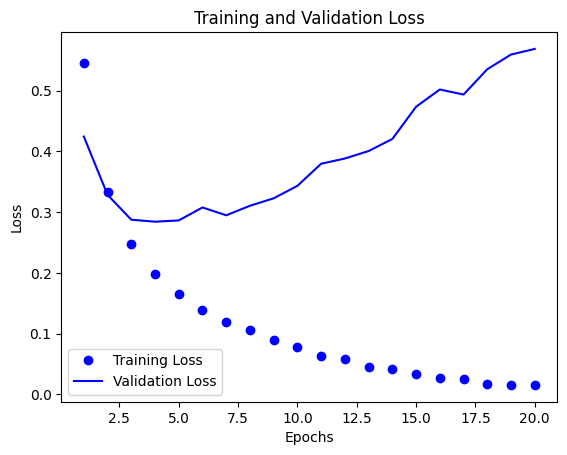

In [26]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training Loss') # 'bo' is for blue dot line 
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss') # 'b' is for blue line 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Training and Validation accuracy 

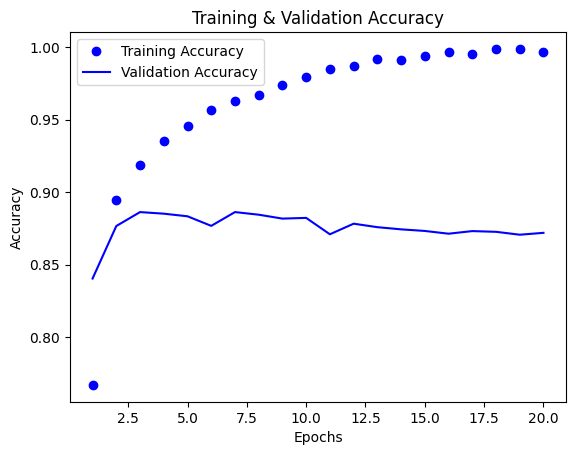

In [30]:
plt.clf() # Clears the figure 
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Observations

> With every epoch, the training loss deacreases and the training accuracy increases <p>
> The model is overfitting, because is performing better in training than in the validation <p>
> To prevent overfitting, we'll stop training after three epochs. There are a range of techniques to mitigate overfitting.

<a class="anchor" id="7th">

# 6. Evaluation on Test Data

</a>

We'll train a new network from scratch for four epochs, and then evaluate it.

In [32]:
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=10000))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

results

Epoch 1/4
49/49 [==============================] - 3s 23ms/step - loss: 0.4810 - accuracy: 0.8085
Epoch 2/4
49/49 [==============================] - 1s 20ms/step - loss: 0.2847 - accuracy: 0.9006
Epoch 3/4
49/49 [==============================] - 1s 20ms/step - loss: 0.2230 - accuracy: 0.9200
Epoch 4/4
782/782 [==============================] - 3s 4ms/step - loss: 0.2845 - accuracy: 0.8861


[0.2845340371131897, 0.8861200213432312]

In [33]:
model.predict(x_test)

782/782 [==============================] - 3s 3ms/step


array([[0.25747237],
       [0.9988564 ],
       [0.9359791 ],
       ...,
       [0.12657258],
       [0.1058305 ],
       [0.77074134]], dtype=float32)